泰坦尼克号问题
===
[Kaggle Link](https://www.kaggle.com/c/titanic)根据训练集，预测乘客是否能够存活。对，这是一个二分类问题，很多分类算法都可以解决。最后的成绩是0.82775

# 1.数据概览

In [13]:
import numpy as np
import pandas as pd
import re
from sklearn.ensemble import RandomForestClassifier, ExtraTreesRegressor
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import KFold, cross_val_score
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl

%matplotlib inline
CHILD_AGE = 18
train_data_df = pd.read_csv("input/train.csv", dtype={"Age": np.float64}, )
test_data_df = pd.read_csv("input/test.csv", dtype={"Age": np.float64}, )

train_y_df = train_data_df['Survived']
train_x_df = train_data_df
full_x_df = pd.concat([train_x_df, test_data_df], axis=0)

print(full_x_df.shape) # 1309,11
print(train_x_df.shape) # 891,11
print(test_data_df.shape) # 418,11
full_x_df.info()

(1309, 12)
(891, 12)
(418, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


我们可以看到一共有891名乘客，其中Age、Cabin和Embarked三个列有缺失值。
<table border="1">
 <tr>
  <th>字段名称</th><th>含义</th>
 </tr>
 <tr>
  <td>PassengerId</td><td>乘客ID</td>
 </tr>
 <tr>
  <td>Survived</td><td>是否存活</td>
 </tr>
 <tr>
  <td>Pclass</td><td>乘客等级(1/2/3等舱位)</td>
 </tr>
 <tr>
  <td>Name</td><td>乘客姓名</td>
 </tr>
 <tr>
  <td>Sex</td><td>性别</td>
 </tr>
 <tr>
  <td>Age</td><td>年龄</td>
 </tr>
 <tr>
  <td>SibSp</td><td>堂兄弟/妹个数</td>
 </tr>
 <tr>
  <td>Parch</td><td>父母与小孩个数</td>
 </tr>
 <tr>
  <td>Ticket</td><td>船票信息</td>
 </tr>
 <tr>
  <td>Fare</td><td>票价</td>
 </tr>
<tr>
  <td>Cabin</td><td>客舱</td>
 </tr>
<tr>
  <td>Embarked</td><td>登船港口</td>
 </tr>
</table>

我们可以先看一下前十行的记录

In [14]:
full_x_df.head(10)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
5,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736


然后看一下生存和死亡的比率

0    0.616162
1    0.383838
Name: Survived, dtype: float64


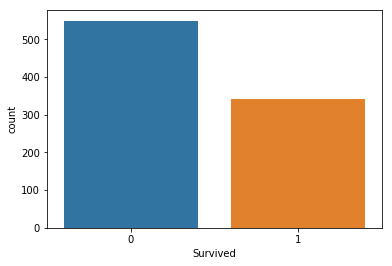

In [19]:
print(train_data_df['Survived'].value_counts(normalize=True))
plt.figure(facecolor='w')
sns.countplot(train_data_df['Survived'])

# 2.逐一分析数据

## 2.1.Pclass--等级

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


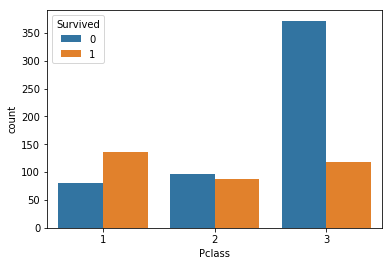

In [16]:
print(train_data_df['Survived'].groupby(train_data_df['Pclass']).mean())
plt.figure(facecolor='w')
sns.countplot(train_data_df['Pclass'], hue=train_data_df['Survived'])

我们可以看到，船舱等级越高的乘客，存活率越高

## 2.2.Name--乘客姓名
乘客姓名本身跟生存率没有什么关系。我们先看一下这个字段大概长什么样子

In [6]:
train_data_df['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

我们可以看到名字中间都包含了类似"Mr."、"Miss."、"Mrs."等等信息，这些不仅仅代表了男性与女性，而且我们还可以看看是否跟生存率有什么关系呢。我们先增加一个列来保存这个信息

In [7]:
train_data_df['Name_Title'] = train_data_df['Name'].apply(lambda x : x.split(',')[1].split('.')[0])
print(train_data_df['Name_Title'].value_counts())

 Mr              517
 Miss            182
 Mrs             125
 Master           40
 Dr                7
 Rev               6
 Major             2
 Col               2
 Mlle              2
 Don               1
 Lady              1
 the Countess      1
 Capt              1
 Mme               1
 Jonkheer          1
 Sir               1
 Ms                1
Name: Name_Title, dtype: int64


来看看这个字段跟最后的生存率有什么关系

In [8]:
print(train_data_df['Survived'].groupby(train_data_df['Name_Title']).mean())

Name_Title
 Capt            0.000000
 Col             0.500000
 Don             0.000000
 Dr              0.428571
 Jonkheer        0.000000
 Lady            1.000000
 Major           0.500000
 Master          0.575000
 Miss            0.697802
 Mlle            1.000000
 Mme             1.000000
 Mr              0.156673
 Mrs             0.792000
 Ms              1.000000
 Rev             0.000000
 Sir             1.000000
 the Countess    1.000000
Name: Survived, dtype: float64


我们再来看一下名字的长度是否跟生存率有关系

In [9]:
train_data_df['Name_Len'] = train_data_df['Name'].apply(lambda x : len(x))
print(train_data_df['Survived'].groupby(pd.qcut(train_data_df['Name_Len'], 5)).mean())

Name_Len
(11.999, 19.0]    0.220588
(19.0, 23.0]      0.301282
(23.0, 27.0]      0.319797
(27.0, 32.0]      0.442424
(32.0, 82.0]      0.674556
Name: Survived, dtype: float64


看到了吗，名字长的人，似乎生存率会比较高啊

## 2.3.Sex--性别
一般我们都说女士优先，所以我们看看性别是否跟生存率有关系

In [10]:
print(train_data_df['Sex'].value_counts(normalize=True))

male      0.647587
female    0.352413
Name: Sex, dtype: float64


In [11]:
print(train_data_df['Survived'].groupby(train_data_df['Sex']).mean())

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


看，女性确实生存率要远远高于男性

## 2.4.Age--年龄
我们常说尊老爱幼，所以看看小朋友和老人是否有更高的生存率，但是年龄这个字段有177个null值。

In [12]:
print(train_data_df['Survived'].groupby(train_data_df['Age'].isnull()).mean())

Age
False    0.406162
True     0.293785
Name: Survived, dtype: float64


In [13]:
print(train_data_df['Survived'].groupby(pd.qcut(train_data_df['Age'],11)).mean())

Age
(0.419, 11.0]     0.573529
(11.0, 18.0]      0.436620
(18.0, 21.0]      0.261538
(21.0, 24.0]      0.424658
(24.0, 27.0]      0.383333
(27.0, 30.0]      0.347222
(30.0, 33.0]      0.444444
(33.0, 36.273]    0.500000
(36.273, 42.0]    0.378788
(42.0, 50.0]      0.384615
(50.0, 80.0]      0.343750
Name: Survived, dtype: float64


## 2.5.SibSp
不太确定这个列跟存活率有什么关系，先做简单分析

In [14]:
print(train_data_df['Survived'].groupby(train_data_df['SibSp']).mean())
print(train_data_df['SibSp'].value_counts())

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64


## 2.6.Parch
跟SibSp一样，先做简单分析

In [15]:
print(train_data_df['Survived'].groupby(train_data_df['Parch']).mean())
print(train_data_df['Parch'].value_counts())

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64
